# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [87]:
# import libraries
from pyspark.sql import Window
from pyspark.sql.window import Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType
import pyspark.sql.functions as func
from pyspark.sql.functions import lit
from pyspark.ml.stat import Correlation

# all pyspark stuff
from pyspark.ml import pipeline
from pyspark.ml.feature import CountVectorizer, VectorAssembler
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import avg, explode, concat, lit, min, max, split, udf, isnull, col, desc
from pyspark.sql import SparkSession, Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [88]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [89]:
spark_json = spark.read.json('mini_sparkify_event_data.json')
spark_json.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [90]:
spark_json.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [91]:
# spark_json.describe('artist').show()
# spark_json.describe('auth').show()
# spark_json.describe('firstName').show()
spark_json.describe('gender').show()

+-------+------+
|summary|gender|
+-------+------+
|  count|278154|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+



In [92]:
# total of 286500 json entries
spark_json.count()
print('total of 286500 json entries')
len(spark_json.columns)
print('total 18 columns')

total of 286500 json entries
total 18 columns


In [93]:
# start cleaning 
spark_json.filter(isnull(spark_json['userId'])).count()
# no null values in userid

0

In [94]:
spark_json.filter(isnull(spark_json['sessionId'])).count()
# no null values in sessionID

0

In [95]:
spark_json.filter(spark_json['userId'] == '').count()
# multiple empty userIDs 

8346

In [96]:
# dropping empty userIds
spark_json = spark_json[spark_json.userId != ""]

In [97]:
spark_json.filter(spark_json['sessionId']=='').count()

0

In [98]:
spark_json = spark_json.dropna(how = 'any', subset = ['userId', 'sessionId'])

In [99]:
spark_json.dropDuplicates(subset = ['userId']).count()

225

In [100]:
spark_json.count()
print('278154 rows left after cleaning')

278154 rows left after cleaning


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [101]:
# converting the json file to a panda df to use head fct.
df = spark_json.toPandas()
df.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [102]:
# registration and ts (time stamp?) are in a weird format -> make this datetime.
# udf = user defined funtion using a lambda function. / 1000 to get rid of the unrequired 000 at the end.
new_ts = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%m-%d-%Y %H:%M:%S"))
spark_json = spark_json.withColumn('updated_registration', new_ts('registration'))
spark_json = spark_json.withColumn('updated_ts', new_ts('ts'))

In [103]:
df.page.value_counts()

NextSong                     228108
Thumbs Up                     12551
Home                          10082
Add to Playlist                6526
Add Friend                     4277
Roll Advert                    3933
Logout                         3226
Thumbs Down                    2546
Downgrade                      2055
Settings                       1514
Help                           1454
Upgrade                         499
About                           495
Save Settings                   310
Error                           252
Submit Upgrade                  159
Submit Downgrade                 63
Cancellation Confirmation        52
Cancel                           52
Name: page, dtype: int64

In [104]:
# define a variable that identifies who submitted a downgrade
downgrade_value  = udf(lambda x: 1 if x == "Submit Downgrade" else 0, IntegerType())
spark_json = spark_json.withColumn("downgrade_value", downgrade_value("page"))

In [105]:
Window.partitionBy('UserId')

In [106]:
#Then identify who (userid) downgraded
window_down_user = Window.partitionBy('UserId')
spark_json = spark_json.withColumn("user_downgrade", max('downgrade_value').over(window_down_user))

In [107]:
Window.partitionBy('UserId')

In [108]:
# identify the churns
churn_identifier = udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, IntegerType())
spark_json = spark_json.withColumn("churn_identifier", churn_identifier("page"))

In [109]:
# final step: find the users that churned
window_churn = Window.partitionBy('UserId')
spark_json = spark_json.withColumn("user_churn", max('churn_identifier').over(window_churn))

In [110]:
# selecting few users to see
spark_json['userId', 'firstName', 'level','updated_ts','user_churn', 'user_downgrade'].dropDuplicates(subset = ['userId']).show(20)

+------+---------+-----+-------------------+----------+--------------+
|userId|firstName|level|         updated_ts|user_churn|user_downgrade|
+------+---------+-----+-------------------+----------+--------------+
|100010| Darianna| free|10-08-2018 12:58:54|         0|             0|
|200002|  Dominic| free|10-01-2018 11:30:30|         0|             0|
|   125|    Mason| free|10-12-2018 04:05:44|         1|             0|
|   124|   Nicole| paid|10-01-2018 15:17:10|         0|             0|
|    51|    Ethan| paid|10-01-2018 12:57:12|         1|             0|
|     7|   Maddox| free|10-03-2018 11:57:49|         0|             0|
|    15|    Panav| paid|10-01-2018 10:23:35|         0|             0|
|    54|    Alexi| paid|10-01-2018 00:32:10|         1|             1|
|   155|   Camila| free|11-02-2018 15:56:25|         0|             0|
|100014|  Rodrigo| paid|10-10-2018 13:12:16|         1|             0|
|   132|    Sadie| free|10-02-2018 08:59:56|         0|             0|
|   15

In [111]:
spark_json.drop_duplicates(['userId', 'gender']).groupby(['user_churn', 'gender']).count().sort("user_churn").show()

+----------+------+-----+
|user_churn|gender|count|
+----------+------+-----+
|         0|     M|   89|
|         0|     F|   84|
|         1|     F|   20|
|         1|     M|   32|
+----------+------+-----+



Given the small sample, gender appears to have an impact on the churn rate, where femals tend to churn less.

In [112]:
spark_json.drop_duplicates(['userId', 'level']).groupby(['user_churn', 'level']).count().sort("user_churn").show()

+----------+-----+-----+
|user_churn|level|count|
+----------+-----+-----+
|         0| free|  149|
|         0| paid|  129|
|         1| paid|   36|
|         1| free|   46|
+----------+-----+-----+



Overall, free and paid users churn on an almost equal rate (between 21 - 23%)

In [113]:
spark_json.drop_duplicates(['userId', 'status']).groupby(['user_churn', 'status']).count().sort("user_churn").show()
# not sure what the status stands for, but again, the overall rate is identical

+----------+------+-----+
|user_churn|status|count|
+----------+------+-----+
|         0|   404|   95|
|         0|   200|  173|
|         0|   307|  171|
|         1|   200|   52|
|         1|   404|   22|
|         1|   307|   52|
+----------+------+-----+



In [114]:
total_songs_df = spark_json.where('page == "NextSong"').groupby(['user_churn', 'userId', 'sessionId', 'gender']).count()\
    .groupby(['user_churn', 'userId', 'gender']).agg({'count': 'avg'})\
    .withColumnRenamed('avg(count)', 'avg_played_songs').toPandas()

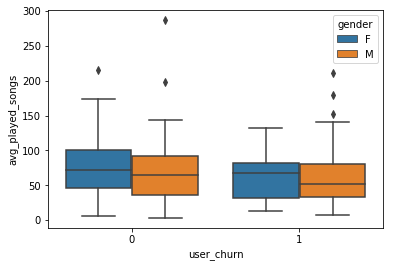

In [115]:
sns.boxplot(x='user_churn',y='avg_played_songs',data=total_songs_df,hue='gender')

The median of female users tends to be equal from femal churning or not. Yet, the churning once have a rahter left skewed distribution, hence, female churners tend to listen less on average.
Men on the other hand do listen more in the median, yet, the upper, lower quantile do match. Likely, men not churning also listen slightly more average songs.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

The general goal is to find variables that make sense in describing if someone will churn or not. Also, we would like those variables to be uncorrelated if possible.

Certainly, it makes sense to use the amount of songs totally played. But naturally, if someone has been part of Sparkly for a long time, he will have higher numbers then someone that just joined. Hence, we will take the rate of the #songs/time. In this way, we can better reflect the true situation

In [116]:
count_tot_songs = spark_json.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'tot_songs')

time_at_sparkly = spark_json.select('userId', 'registration', 'ts').withColumn('tot_lifetime', (spark_json.ts - spark_json.registration))\
    .groupBy('userId').agg({'tot_lifetime' : 'max'})\
    .withColumnRenamed('max(tot_lifetime)', 'tot_lifetime')\
    .select('userId', (col('tot_lifetime')/1000/3600/24).alias('tot_lifetime'))

var_1 = time_at_sparkly.join(count_tot_songs, "userId")
var_1 = var_1.withColumn("ratio_songs_time", col("tot_songs") / col("tot_lifetime")) 

var_1 = var_1.drop("tot_songs", "tot_lifetime")
var_1.head(10)

[Row(userId='100010', ratio_songs_time=6.847141574652864),
 Row(userId='200002', ratio_songs_time=6.764216985594723),
 Row(userId='125', ratio_songs_time=0.15424116963623655),
 Row(userId='124', ratio_songs_time=36.676420241322894),
 Row(userId='51', ratio_songs_time=126.64574639273998),
 Row(userId='7', ratio_songs_time=2.7618166883613084),
 Row(userId='15', ratio_songs_time=40.30889824286323),
 Row(userId='54', ratio_songs_time=31.033386540168586),
 Row(userId='155', ratio_songs_time=42.53689982508206),
 Row(userId='100014', ratio_songs_time=3.6434838038819755)]

now lets have a rate of thumbs up and then thumbs down vs the total amount of songs heard

In [117]:
thumbs_up = spark_json.select('userId', 'page').where(spark_json.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_up')

var_2 = thumbs_up.join(count_tot_songs, "userId")
var_2 = var_2.withColumn("ratio_thumps_up", col("tot_thumbs_up") / col("tot_songs")) 

var_2 = var_2.drop("tot_thumbs_up", "tot_songs")
var_2.head(10)

[Row(userId='100010', ratio_thumps_up=0.04461942257217848),
 Row(userId='200002', ratio_thumps_up=0.04430379746835443),
 Row(userId='124', ratio_thumps_up=0.03544041450777202),
 Row(userId='51', ratio_thumps_up=0.040584415584415584),
 Row(userId='7', ratio_thumps_up=0.03482587064676617),
 Row(userId='15', ratio_thumps_up=0.03555750658472344),
 Row(userId='54', ratio_thumps_up=0.04742508001163805),
 Row(userId='155', ratio_thumps_up=0.05788423153692615),
 Row(userId='100014', ratio_thumps_up=0.054838709677419356),
 Row(userId='132', ratio_thumps_up=0.041666666666666664)]

In [118]:
thumbs_down = spark_json.select('userId', 'page').where(spark_json.page == 'Thumbs Down').groupBy('userId').count().withColumnRenamed('count', 'tot_thumbs_down')

var_3 = thumbs_down.join(count_tot_songs, "userId")
var_3 = var_3.withColumn("ratio_thumps_down", col("tot_thumbs_down") / col("tot_songs")) 

var_3 = var_3.drop("tot_thumbs_down", "tot_songs")
var_3.head(10)

[Row(userId='100010', ratio_thumps_down=0.013123359580052493),
 Row(userId='200002', ratio_thumps_down=0.012658227848101266),
 Row(userId='124', ratio_thumps_down=0.00849740932642487),
 Row(userId='51', ratio_thumps_down=0.008522727272727272),
 Row(userId='7', ratio_thumps_down=0.004975124378109453),
 Row(userId='15', ratio_thumps_down=0.006145741878841089),
 Row(userId='54', ratio_thumps_down=0.008437590922315974),
 Row(userId='155', ratio_thumps_down=0.0029940119760479044),
 Row(userId='100014', ratio_thumps_down=0.00967741935483871),
 Row(userId='132', ratio_thumps_down=0.007378472222222222)]

Lets also have a look how many songs are on avg listend to per session.

In [119]:
var_4  = spark_json.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby('userId')\
          .agg({'count' : 'avg'}).withColumnRenamed('avg(count)', 'avg_played_songs')

var_4.head(10)

[Row(userId='100010', avg_played_songs=39.285714285714285),
 Row(userId='200002', avg_played_songs=64.5),
 Row(userId='125', avg_played_songs=8.0),
 Row(userId='51', avg_played_songs=211.1),
 Row(userId='124', avg_played_songs=145.67857142857142),
 Row(userId='7', avg_played_songs=21.428571428571427),
 Row(userId='54', avg_played_songs=81.17142857142858),
 Row(userId='15', avg_played_songs=136.71428571428572),
 Row(userId='155', avg_played_songs=136.66666666666666),
 Row(userId='100014', avg_played_songs=42.833333333333336)]

Certainly, having friends in the same network is important too. Hence, lets just add this information as we have it! 

In [120]:
var_5 = spark_json.select('userId', 'page').where(spark_json.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'tot_friends')
var_5.head(10)

[Row(userId='100010', tot_friends=4),
 Row(userId='200002', tot_friends=4),
 Row(userId='51', tot_friends=28),
 Row(userId='124', tot_friends=74),
 Row(userId='7', tot_friends=1),
 Row(userId='54', tot_friends=33),
 Row(userId='15', tot_friends=31),
 Row(userId='155', tot_friends=11),
 Row(userId='132', tot_friends=41),
 Row(userId='154', tot_friends=3)]

Lets now add the total listen time.

In [121]:
var_6 = spark_json.select("userId", 'length').groupBy('userId').sum().withColumnRenamed('sum(length)', 'tot_listen_time')
var_6.head(10)

[Row(userId='100010', tot_listen_time=66940.89735000003),
 Row(userId='200002', tot_listen_time=94008.87593999993),
 Row(userId='125', tot_listen_time=2089.1131000000005),
 Row(userId='51', tot_listen_time=523275.8428000004),
 Row(userId='124', tot_listen_time=1012312.0927899999),
 Row(userId='7', tot_listen_time=38034.08710000002),
 Row(userId='54', tot_listen_time=711344.9195400011),
 Row(userId='15', tot_listen_time=477307.60581000015),
 Row(userId='155', tot_listen_time=198779.2919),
 Row(userId='132', tot_listen_time=483118.9038399997)]

As we have seen, there might be a light effect of the gender. so we should include this. We codeFemale as 0 and Male as 1

In [122]:
var_7 = spark_json.select('userId', 'gender').dropDuplicates().replace(['F', 'M'], ['0', '1'], 'gender').select('userId', col('gender').cast('int'))
var_7.head(10)

[Row(userId='44', gender=0),
 Row(userId='46', gender=0),
 Row(userId='41', gender=0),
 Row(userId='72', gender=0),
 Row(userId='300023', gender=0),
 Row(userId='39', gender=0),
 Row(userId='100010', gender=0),
 Row(userId='40', gender=0),
 Row(userId='94', gender=0),
 Row(userId='35', gender=0)]

In [123]:
y = spark_json.select('userId', col('user_churn').alias('y')).dropDuplicates()
y.head(10)

[Row(userId='100010', y=0),
 Row(userId='200002', y=0),
 Row(userId='125', y=1),
 Row(userId='124', y=0),
 Row(userId='51', y=1),
 Row(userId='7', y=0),
 Row(userId='15', y=0),
 Row(userId='54', y=1),
 Row(userId='155', y=0),
 Row(userId='100014', y=1)]

In [124]:
data_mat = var_1.join(var_2, 'userId', 'inner').join(var_3, 'userId', 'inner').join(var_4, 'userId', 'inner')\
                .join(var_5, 'userId', 'inner').join(var_6, 'userId', 'inner').join(var_7, 'userId', 'inner')\
                .join(y, 'userId', 'inner').drop('userId')

data_mat.show()

+------------------+--------------------+--------------------+------------------+-----------+------------------+------+---+
|  ratio_songs_time|     ratio_thumps_up|   ratio_thumps_down|  avg_played_songs|tot_friends|   tot_listen_time|gender|  y|
+------------------+--------------------+--------------------+------------------+-----------+------------------+------+---+
| 6.847141574652864| 0.04461942257217848|0.013123359580052493|39.285714285714285|          4| 66940.89735000003|     0|  0|
| 6.764216985594723| 0.04430379746835443|0.012658227848101266|              64.5|          4| 94008.87593999993|     1|  0|
|36.676420241322894| 0.03544041450777202| 0.00849740932642487|145.67857142857142|         74|1012312.0927899999|     0|  0|
|126.64574639273998|0.040584415584415584|0.008522727272727272|             211.1|         28| 523275.8428000004|     1|  1|
|2.7618166883613084| 0.03482587064676617|0.004975124378109453|21.428571428571427|          1| 38034.08710000002|     1|  0|
| 40.308

In [125]:
pd_design_mat = data_mat.toPandas()

In [126]:
pd_design_mat.isna().sum()

ratio_songs_time     0
ratio_thumps_up      0
ratio_thumps_down    0
avg_played_songs     0
tot_friends          0
tot_listen_time      0
gender               0
y                    0
dtype: int64

In [127]:
pd_design_mat.isnull().sum()

ratio_songs_time     0
ratio_thumps_up      0
ratio_thumps_down    0
avg_played_songs     0
tot_friends          0
tot_listen_time      0
gender               0
y                    0
dtype: int64

In [128]:
pd_design_mat.columns

Index(['ratio_songs_time', 'ratio_thumps_up', 'ratio_thumps_down',
       'avg_played_songs', 'tot_friends', 'tot_listen_time', 'gender', 'y'],
      dtype='object')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [129]:
# vectorization so that we can fit spark ml models

col_names = ['ratio_songs_time', 'ratio_thumps_up', 'ratio_thumps_down', 'avg_played_songs', 'tot_friends', 'gender']
vec_assemble = VectorAssembler(inputCols = col_names, outputCol = "VectFeatures")
data_mat = vec_assemble.transform(data_mat)
data_mat.show()

+------------------+--------------------+--------------------+------------------+-----------+------------------+------+---+--------------------+
|  ratio_songs_time|     ratio_thumps_up|   ratio_thumps_down|  avg_played_songs|tot_friends|   tot_listen_time|gender|  y|        VectFeatures|
+------------------+--------------------+--------------------+------------------+-----------+------------------+------+---+--------------------+
| 6.847141574652864| 0.04461942257217848|0.013123359580052493|39.285714285714285|          4| 66940.89735000003|     0|  0|[6.84714157465286...|
| 6.764216985594723| 0.04430379746835443|0.012658227848101266|              64.5|          4| 94008.87593999993|     1|  0|[6.76421698559472...|
|36.676420241322894| 0.03544041450777202| 0.00849740932642487|145.67857142857142|         74|1012312.0927899999|     0|  0|[36.6764202413228...|
|126.64574639273998|0.040584415584415584|0.008522727272727272|             211.1|         28| 523275.8428000004|     1|  1|[126.64

In [130]:
model_data = data_mat.select(data_mat.y.alias("label"), data_mat.VectFeatures.alias("features"))
model_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[6.84714157465286...|
|    0|[6.76421698559472...|
|    0|[36.6764202413228...|
|    1|[126.645746392739...|
|    0|[2.76181668836130...|
|    0|[40.3088982428632...|
|    1|[31.0333865401685...|
|    0|[42.5368998250820...|
|    1|[3.64348380388197...|
|    0|[34.4450694808416...|
|    1|[39.8214151287559...|
|    0|[6.81243497743963...|
|    0|[37.0572214657886...|
|    0|[59.5493305706088...|
|    1|[4.92748824604831...|
|    1|[59.9460426459515...|
|    0|[18.7890855916119...|
|    0|[3.33856881464318...|
|    0|[63.4297235255497...|
|    1|[9.18369910155824...|
+-----+--------------------+
only showing top 20 rows



In [131]:
# calculate the correlation for the features.
corr_matt = Correlation.corr(model_data, 'features').collect()[0][0]
corrmatrix = corr_matt.toArray().tolist()
df_corr = spark.createDataFrame(corrmatrix, col_names)
pd_corr = df_corr.toPandas()

In [132]:
# transform for plotting
pd_corr = df_corr.toPandas()

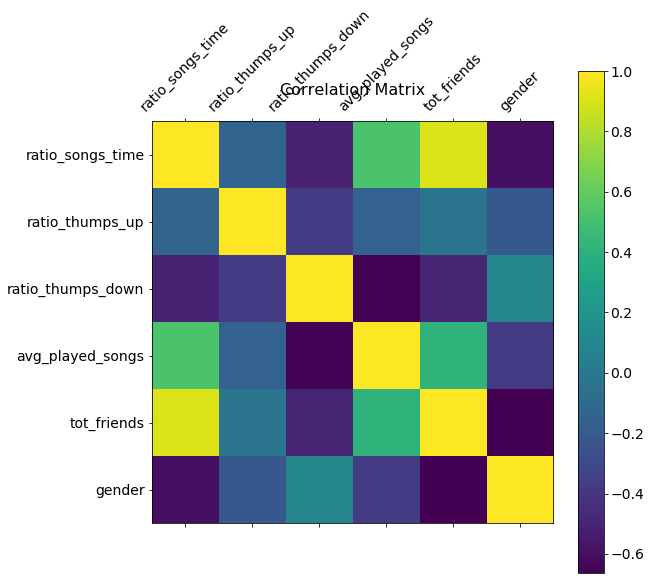

In [133]:
# Plot the correlation matrix

f = plt.figure(figsize=(9, 9))
plt.matshow(pd_corr.corr(), fignum=f.number)
plt.xticks(range(pd_corr.shape[1]), pd_corr.columns, fontsize=14, rotation=45)
plt.yticks(range(pd_corr.shape[1]), pd_corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);


In [134]:
# create train and test dataset
train, test = model_data.randomSplit([0.75, 0.25], seed = 42)
train = train.cache()

In [135]:
print("The train set ration of 1 (churn) to 0 (stay) is", train.where(train.label == '1').count() / train.where(train.label == '0').count()) 

The train set ration of 1 (churn) to 0 (stay) is 0.2773109243697479


In [136]:
print("The test set ration of 1 (churn) to 0 (stay) is", test.where(test.label == '1').count() / test.where(test.label == '0').count()) 

The test set ration of 1 (churn) to 0 (stay) is 0.3225806451612903


Both, the train and test dataset are moderately balanced. We will fit the models against the F1-score which is relaitvely robust against mild imbalances. Hence no down / up sampling or synthetic minority oversampling is required.

In [137]:
# Initialize four models
clf_LR = LogisticRegression(maxIter=50)
clf_DT = DecisionTreeClassifier(seed=7)
clf_RF = RandomForestClassifier(seed=7)
clf_SVM = LinearSVC() # to account the long computation times

In [138]:
# Create the evaluator and parameter grid on which the models are trained on.
f1_evaluation = MulticlassClassificationEvaluator(metricName = 'f1')
param_grid = ParamGridBuilder().build()

In [139]:
# collect results on the learners
all_results = {}
for clf in [clf_RF, clf_DT, clf_LR]:
#for clf in [clf_LR, clf_DT, clf_RF, clf_SVM]:

    cross_val_model = CrossValidator(estimator = clf, estimatorParamMaps = param_grid, evaluator = f1_evaluation, numFolds = 2)
    
    model_results = {}
    
    # get the classifier name
    clf_name = clf.__class__.__name__
    
    
    # fit the dataset
    print(f'{clf_name} is training...')
    start = time.time() 
    model = cross_val_model.fit(train)
    end = time.time() 
    model_results['train_time'] = round(end-start,2)
    
    # predict
    print(f'{clf_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_results['train_f1_avg'] = model.avgMetrics
    
    # predict
    print(f'{clf_name} is predicting...')
    start = time.time() 
    pred_test = model.transform(test)
    end = time.time()
    model_results['pred_time'] = round(end-start,2)
    
    #metrics
    print(f'{clf_name} is evaluating...')    
    model_results['f1_test'] = f1_evaluation.evaluate(pred_test.select('label','prediction'),{f1_evaluation.metricName: 'f1'})
    print('Test F1-score: ',model_results['f1_test'])
    all_results[clf_name] = model_results
    
all_results_df = pd.DataFrame(all_results)
# all_results_df.to_csv('baseline.csv')
all_results_df

RandomForestClassifier is training...
RandomForestClassifier is predicting...
RandomForestClassifier is predicting...
RandomForestClassifier is evaluating...
Test F1-score:  0.6887340301974448
DecisionTreeClassifier is training...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is predicting...
DecisionTreeClassifier is evaluating...
Test F1-score:  0.7145931543349046
LogisticRegression is training...
LogisticRegression is predicting...
LogisticRegression is predicting...
LogisticRegression is evaluating...
Test F1-score:  0.7520931925737168


,RandomForestClassifier,DecisionTreeClassifier,LogisticRegression
f1_test,0.688734,0.714593,0.752093
pred_time,0.04,0.05,0.05
train_f1_avg,[0.7313190730837789],[0.7414597531670701],[0.7721352647352648]
train_time,95.88,63.07,149.35


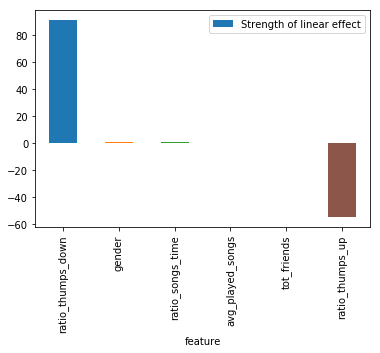

In [140]:
coefficients = pd.DataFrame({'feature': col_names, 'Strength of linear effect': model.bestModel.coefficients})
_ = coefficients.sort_values('Strength of linear effect', ascending=False)[:15].plot(x='feature', y='Strength of linear effect', kind='bar')

In [141]:
coefficients

,feature,Strength of linear effect
0,ratio_songs_time,0.090461
1,ratio_thumps_up,-55.286147
2,ratio_thumps_down,91.046316
3,avg_played_songs,-0.004898
4,tot_friends,-0.094134
5,gender,0.254894
